## EDA

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud

In [24]:
df = pd.read_csv('../data/interim.csv', index_col=0)
df.shape

(18963, 2)

In [25]:
df.nunique()

complaint_what_happened    18824
ticket_classification         78
dtype: int64

En nuestro dataset hay 2 columnas, que fueron las que seleccionamos como relevantes para nuestro propósito, y 18,963 registros, aunque parece ser que algunas se repiten, ya que hay 18,824 instancias únicas, que es mayor al número de registros totales.

Podemos ver que hay 78 categorías distintas a predecir, es decir, las 18,963 quejas que hay, cada una de ellas pertenecerá a una categoría.

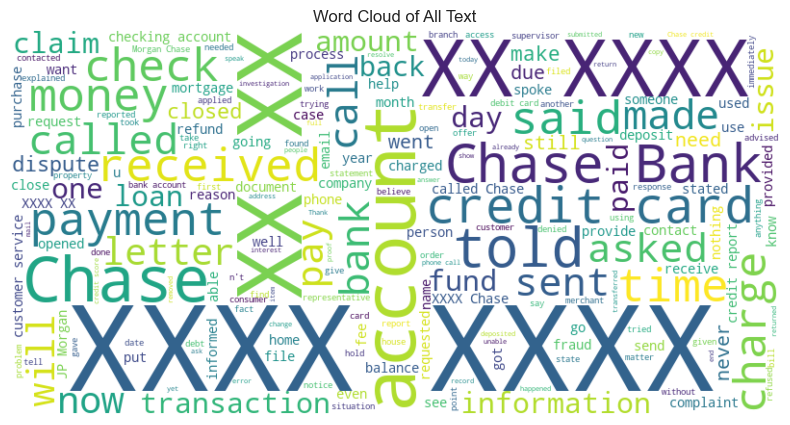

In [26]:
# Word cloud for all text
all_text = ' '.join(df['complaint_what_happened'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Text')
plt.show()

Al haber instancias de 'XXXX' o 'XX', procederemos a quitar esto de la columna.

In [27]:
def remove_sensitive_info(text):
    if isinstance(text, str):  # Ensure the input is a string
        return re.sub(r'X{2,}', '', text)  # Remove XX, XXX, XXXX
    return text

df['complaint_what_happened'] = df['complaint_what_happened'].apply(remove_sensitive_info)

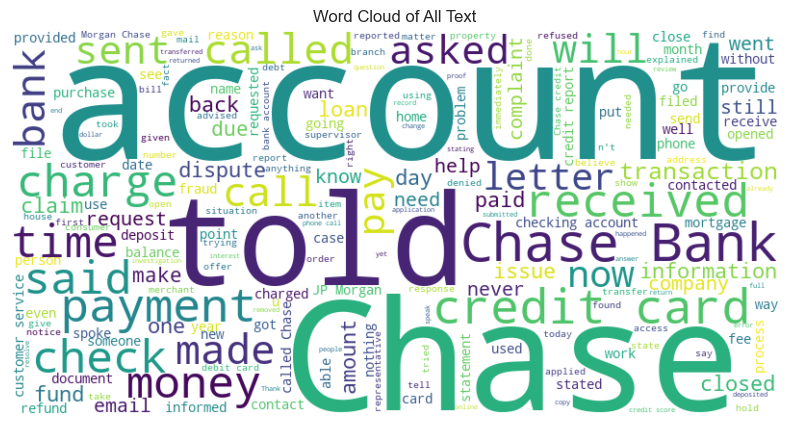

In [28]:
# Word cloud for all text
all_text = ' '.join(df['complaint_what_happened'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Text')
plt.show()

Ahora sí, podemos ver las palabras más comunes en nuestra sección de quejas.

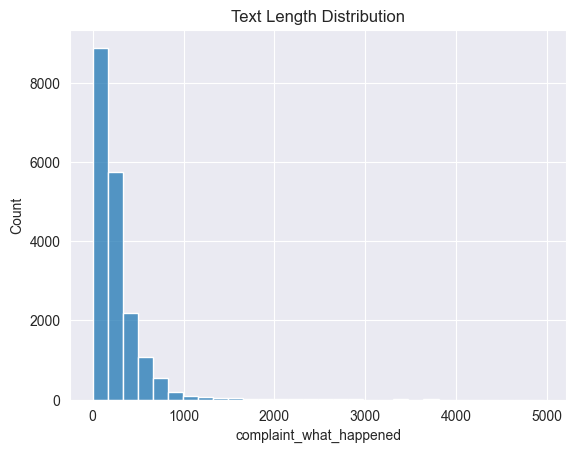

In [29]:
# Text length analysis
length = df.copy()
length['complaint_what_happened'] = length['complaint_what_happened'].apply(lambda x: len(x.split()))
sns.histplot(length['complaint_what_happened'], bins=30)
plt.title('Text Length Distribution')
plt.show()

Aquí podemos apreciar que la mayoría de quejas son largas, contienen mucho texto.

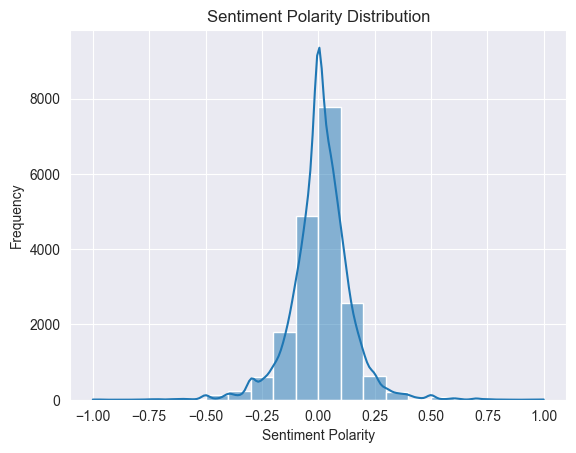

In [30]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns value between -1 (negative) and 1 (positive)

sentiments = df.copy()

sentiments['sentiment'] = sentiments['complaint_what_happened'].dropna().astype(str).apply(get_sentiment)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(sentiments['sentiment'], bins=20, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


Aquí usamos la librería de textblob para realizar un breve análisis de sentimientos, en donde el -1 indica un sentimiento de negatividad, mientras que el 1 indica un sentimiento de positividad.

Como podemos observar, la mayoría de quejas se encuentran dentro del rango de -0.25 a 0.25, lo cual indica que la mayoría de quejas son neutrales.


In [31]:
pd.options.display.max_rows = 4000
print(df['ticket_classification'].value_counts())

ticket_classification
Credit card or prepaid card+General-purpose credit card or charge card                                         4918
Checking or savings account+Checking account                                                                   3788
Credit reporting, credit repair services, or other personal consumer reports+Credit reporting                  2011
Bank account or service+Checking account                                                                       1242
Mortgage+Conventional home mortgage                                                                             955
Mortgage+Conventional fixed mortgage                                                                            785
Mortgage+FHA mortgage                                                                                           496
Debt collection+Credit card debt                                                                                427
Money transfer, virtual currency, or money service

Al contar con 78 categorías distintas, imprimimos las veces que se repite cada una, y nos encontramos con que hay varias categorías que sólo aparecen 1 vez. Procederemos a establecer un threshold para que sólo se tomen en cuenta las categorías con un mínimo de 100 apariciones, esto para reducir el ruido a la hora de entrenar los modelos seleccionados.

In [32]:
category_counts = df['ticket_classification'].value_counts()
# Filter categories that meet the threshold
filters = category_counts[category_counts >= 100].index
df = df[df['ticket_classification'].isin(filters)]

Class Counts:
ticket_classification
Credit card or prepaid card+General-purpose credit card or charge card                           4918
Checking or savings account+Checking account                                                     3788
Credit reporting, credit repair services, or other personal consumer reports+Credit reporting    2011
Bank account or service+Checking account                                                         1242
Mortgage+Conventional home mortgage                                                               955
Mortgage+Conventional fixed mortgage                                                              785
Mortgage+FHA mortgage                                                                             496
Debt collection+Credit card debt                                                                  427
Money transfer, virtual currency, or money service+Domestic (US) money transfer                   344
Bank account or service+Other bank product/ser

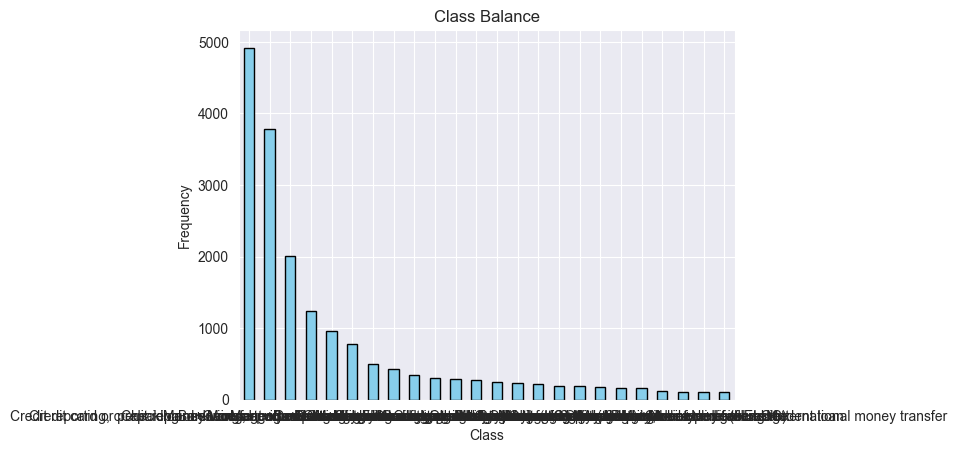

In [42]:
# Count occurrences of each class
class_counts = df['ticket_classification'].value_counts()

# Calculate class percentages
class_percentages = df['ticket_classification'].value_counts(normalize=True) * 100

# Display class balance
print("Class Counts:")
print(class_counts)
print("\nClass Percentages:")
print(class_percentages)

class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Class Balance")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()


El balance de clases es muy malo, lo cual va a afectar a nuestro modelo, ya que hay clases que no tienen suficiente representación.

In [33]:
df['ticket_classification'].nunique()

24

Con esto, reducimos el número de categorías de 78 a 24. Ahora pasaremos al preprocesamiento para pasar el dataset a los modelos.

### Preprocesamiento

Usaremos la libreria de NLTK para quitar las stop words del texto de la columna 'complaint_what_happened' y también para tokenizar el texto.


El quitar las stop words nos ayuda a que haya menos ruido a la hora de entrenar nuestro modelo, ya que son palabras que no contienen mucha información del texto en sí, se pueden quitar para simplificar el entrenamiento y que sea más preciso. Ejemplos de stop words en inglés son 'the, 'a', 'on', 'in' etc.

El tokenizar el texto nos sirve para quebrar el texto en palabras y eliminar caracteres especiales y puntuación, este paso es importante para eliminar las stop words efectivamente.

In [34]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt_tab')

In [35]:
df['complaint_what_happened'].head()

0    Good morning my name is   and I appreciate it ...
1    I upgraded my   card in //2018 and was told by...
3    On //2018, while trying to book a     ticket, ...
4    my grand son give me check for {$1600.00} i de...
5                        Can you please remove inquiry
Name: complaint_what_happened, dtype: object

In [36]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    # Tokenizar el texto
    tokens = word_tokenize(text)

    # Filtrar palabras vacías y caracteres especiales
    filtered_text = [word for word in tokens if word.lower() not in stop_words and not re.match(r'[^\w\s]', word)]

    # Unir las palabras filtradas en una cadena
    return ' '.join(filtered_text)

In [37]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(remove_stopwords)

In [38]:
df['complaint_what_happened'].head()

0    Good morning name appreciate could help put st...
1    upgraded card told agent upgrade anniversary d...
3    trying book ticket came across offer 300.00 ap...
4    grand son give check 1600.00 deposit chase acc...
5                                please remove inquiry
Name: complaint_what_happened, dtype: object

Así quedan las quejas después de la tokenización y remover las stop words.

In [39]:
df['complaint_what_happened'].apply(lambda x: len(x.split(' '))).sum()

np.int64(2084903)

Después de aplicar estas técnicas, nos quedan 2,084,903 palabras con las cuales trabajar.

Ya podemos guardar nuestro csv para poder entrenar nuestros modelos.

In [41]:
df.to_csv('../data/processed.csv')